Should I Collect More Data?
===

Author: Nathan A. Mahynski

Date: 2023/09/12

Description: How do I know if more data will help me or not?

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/mahynski/pychemauth/blob/main/docs/jupyter/api/learning_curves.ipynb)

In [1]:
if 'google.colab' in str(get_ipython()):
    !pip install git+https://github.com/mahynski/pychemauth@main
    import os
    os.kill(os.getpid(), 9) # Automatically restart the runtime to reload libraries

In [2]:
try:
    import pychemauth
except:
    raise ImportError("pychemauth not installed")

import matplotlib.pyplot as plt
%matplotlib inline

import watermark
%load_ext watermark

%load_ext autoreload
%autoreload 2

In [3]:
import sklearn
import imblearn

import numpy as np

from pychemauth.classifier.simca import SIMCA_Authenticator

from sklearn.model_selection import train_test_split, LearningCurveDisplay, RepeatedStratifiedKFold, GridSearchCV

In [4]:
%watermark -t -m -v --iversions

Python implementation: CPython
Python version       : 3.11.4
IPython version      : 8.14.0

Compiler    : GCC 12.2.0
OS          : Linux
Release     : 6.2.0-34-generic
Machine     : x86_64
Processor   : x86_64
CPU cores   : 40
Architecture: 64bit

matplotlib: 3.7.2
json      : 2.0.9
sklearn   : 1.3.0
imblearn  : 0.11.0
numpy     : 1.24.3
pychemauth: 0.0.0b3
watermark : 2.4.3



<h3>Load the Data</h3>

In [5]:
from sklearn.datasets import load_wine as load_data
X, y = load_data(return_X_y=True, as_frame=True)

In [6]:
# Here we have 3 different classes of wine 
np.unique(y)

array([0, 1, 2])

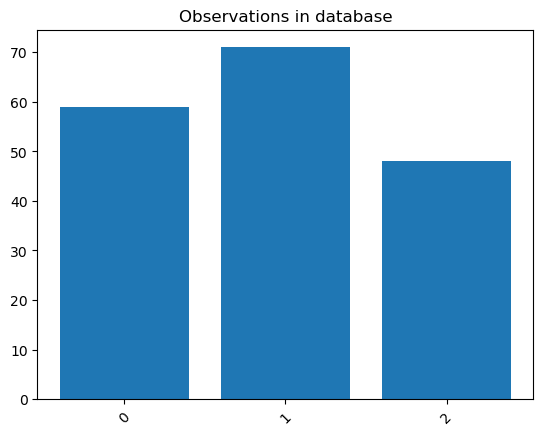

In [7]:
plt.bar(
    x=np.unique(y),
    height=[np.sum(y == class_) for class_ in np.unique(y)]
)
plt.xticks([0, 1, 2])
plt.title('Observations in database')
_ = plt.xticks(rotation=45)

In [8]:
X_train, X_test, y_train, y_test = train_test_split(
    X.values,
    y.values, # Let's try to predict the salary based on the other numerical features.
    shuffle=True,
    random_state=42,
    test_size=0.2,
    stratify=y # It is usually important to balance the test and train set so they have the same fraction of classes
)

Learning Curves
---

[Learning curves](https://scikit-learn.org/stable/auto_examples/model_selection/plot_learning_curve.html#learning-curve) illustrate the effect of collecting more data to use during the training process.  Data is often scarce and can be expensive to collect, but learning curves help you extrapolate a model's performance if you did collect more data.  This means we can estimate the value produced (degree of model improvement) for a given investment (cost to collect more data).

In practice, this is done by training on small subsets of your data, of progressively increasing size, until you reach all your available data.  This way, you build a curve from the small(er) data limit up to your current capacity and hopefully extrapolate the results. For each subset of data, some form of CV is performed to get a mean and standard deviation (uncertainty) from the test folds.  This what is reported below.

<h3>Extrapolating Model Performance</h3>

In [9]:
compliant = SIMCA_Authenticator(
    n_components=2,
    alpha=0.05,
    scale_x=True,
    style='dd-simca',
    robust="semi",
    sft=False,
    target_class=0, # Let's model class 0
    use='compliant' # Using a compliant approach will use the other classes provided at training time
)

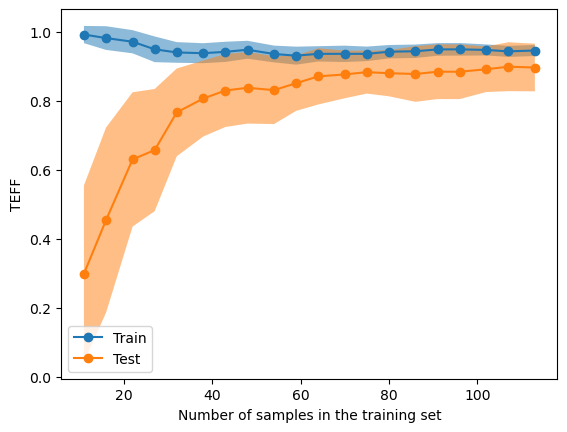

In [10]:
common_params = {
    "X": X_train,
    "y": y_train,
    "train_sizes": np.linspace(0.1, 1.0, 20), 
    "cv": RepeatedStratifiedKFold(n_repeats=10, n_splits=5, random_state=0),
    "score_type": "both", # Get both test and train results
    "n_jobs": -1,
    "line_kw": {"marker": "o"},
    "std_display_style": "fill_between",
    "score_name": "TEFF",
}

_ = LearningCurveDisplay.from_estimator(compliant, **common_params)

Unsurprisingly, this model performs quite well and the train and test performances have converged.  We probably don't need more data to improve this particular model.

<h3>Incorporating Hyperparameter Search Uncertainty</h3>

But what if we need to optimize the hyperparameters, too?  We should use a nested CV approach to examine the uncertainty in the determination of those hyperparameters.

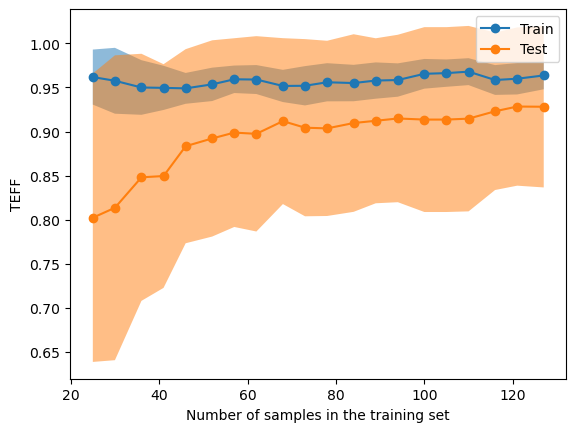

In [11]:
k_inner = 5
k_outer = 10
n_repeats = 10

compliant_pipeline = imblearn.pipeline.Pipeline(
    steps=[
        ("simca", SIMCA_Authenticator(
            n_components=1, 
            alpha=0.05, 
            scale_x=True, 
            style='dd-simca', 
            robust="semi",
            sft=False,
            target_class=0, 
            use='compliant'
        )
    )
])

param_grid = [{
    'simca__n_components':np.arange(1, 4),
    'simca__alpha': [0.01, 0.03, 0.05],
}]

gs = GridSearchCV(
    estimator=compliant_pipeline,
    param_grid=param_grid,
    n_jobs=-1,
    cv=sklearn.model_selection.StratifiedKFold(n_splits=k_inner, shuffle=True, random_state=0),
    error_score=0,
    refit=True
)

common_params = {
    "X": X_train,
    "y": y_train,
    "train_sizes": np.linspace(0.2, 1.0, 20), # Be sure to consider how low you can go with this (see below)
    "cv": RepeatedStratifiedKFold(n_repeats=n_repeats, n_splits=k_outer, random_state=0),
    "score_type": "both",
    "n_jobs": -1,
    "line_kw": {"marker": "o"},
    "std_display_style": "fill_between",
    "score_name": "TEFF",
}

_ = LearningCurveDisplay.from_estimator(gs, **common_params)

This model's performance seems stable so adding more data is unlikely to improve it; this is expected given the good performance already seen.  Note the uncertainty is much higher because we are also incorporating the hyperparameter search now.

Note that when nesting cross-validators like this we should think a little bit about how much data is available.  The first point tested above uses 20% of the available data.  Class 0 has 47 examples in the dataset being used.  k_outer splits are repeatedly used to estimate uncertainty.  This means (k_outer-1)/k_outer are available for training; we should have some data in the test and train folds, so with k_inner = 5 we need to have atleast 5 example sent to each of these loops.

Note that since we are using Stratified splitters a warning will be thrown if an even split cannot be made, which will be set off by the class with the least observations over all (in this case it is actually class 2).

In [12]:
min_fraction = 0.2

np.sum(y_train == 0)*(k_outer-1)/(k_outer)*min_fraction > k_inner

True